In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# To get reproducible results with Keras
from numpy.random import seed
# from tensorflow import set_random_seed
# set_random_seed(2)
import tensorflow 
tensorflow.random.set_seed(2)
from keras.models import Model, Sequential
from keras.layers import Dense, Input, LSTM, Dropout
from keras.layers import TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

from keras import regularizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pyFTS.benchmarks import Measures
import statistics
from pyFTS.common.Util import persist_obj, load_obj
from pyFTS.models.multivariate import common, variable, wmvfts
from pyFTS.partitioners import Grid
from pyFTS.common import Membership
import math
import pyFTS
import datetime
from pyFTS.common import Util
import seaborn as sns

In [39]:
def sample_first_prows(data, perc=0.75):
    return data.head(int(len(data)*(perc))-1)

In [7]:
# To get reproducible results with Keras
from numpy.random import seed
seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)
import tensorflow
tensorflow.random.set_seed(2)

In [8]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [9]:
dataset = pd.read_csv('/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/energydata_complete.csv')
data = dataset.drop(labels=['date','rv1','rv2'], axis=1)
values = data.values
values

array([[ 60.        ,  30.        ,  19.89      , ...,   7.        ,
         63.        ,   5.3       ],
       [ 60.        ,  30.        ,  19.89      , ...,   6.66666667,
         59.16666667,   5.2       ],
       [ 50.        ,  30.        ,  19.89      , ...,   6.33333333,
         55.33333333,   5.1       ],
       ...,
       [270.        ,  10.        ,  25.5       , ...,   3.66666667,
         25.33333333,  13.26666667],
       [420.        ,  10.        ,  25.5       , ...,   3.83333333,
         26.16666667,  13.23333333],
       [430.        ,  10.        ,  25.5       , ...,   4.        ,
         27.        ,  13.2       ]])

In [50]:
train = sample_first_prows(data,0.75)
test = data.iloc[max(train.index)+2:]

In [51]:
test.shape

(4934, 26)

In [10]:
data.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint'],
      dtype='object')

In [11]:
len(data.columns)

26

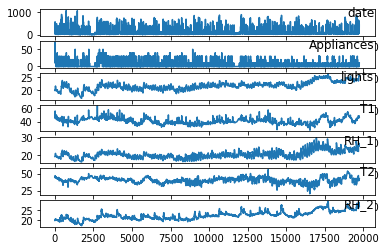

In [12]:
from matplotlib import pyplot
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()
pyplot.close('all')

In [13]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[0,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var18(t-1),var19(t-1),var20(t-1),var21(t-1),var22(t-1),var23(t-1),var24(t-1),var25(t-1),var26(t-1),var1(t)
1,0.046729,0.428571,0.32735,0.566187,0.225345,0.684038,0.215188,0.746066,0.351351,0.764262,...,0.661412,0.223032,0.677290,0.372990,0.097674,0.894737,0.500000,0.953846,0.538462,0.046729
2,0.046729,0.428571,0.32735,0.541326,0.225345,0.682140,0.215188,0.748871,0.351351,0.782437,...,0.660155,0.226500,0.678532,0.369239,0.100000,0.894737,0.476190,0.894872,0.533937,0.037383
3,0.037383,0.428571,0.32735,0.530502,0.225345,0.679445,0.215188,0.755569,0.344745,0.778062,...,0.655586,0.219563,0.676049,0.365488,0.102326,0.894737,0.452381,0.835897,0.529412,0.037383
4,0.037383,0.571429,0.32735,0.524080,0.225345,0.678414,0.215188,0.758685,0.341441,0.770949,...,0.650788,0.219563,0.671909,0.361736,0.104651,0.894737,0.428571,0.776923,0.524887,0.046729
5,0.046729,0.571429,0.32735,0.531419,0.225345,0.676727,0.215188,0.758685,0.341441,0.762697,...,0.650788,0.219563,0.671909,0.357985,0.106977,0.894737,0.404762,0.717949,0.520362,0.037383


In [14]:
len(reframed.values)

19734

In [15]:
values = reframed.values
train_size=int(len(values) *0.75)
test_size = int(len(values)) - train_size
print(test_size)

4934


In [16]:
# split into train and test sets
train_X, train_y = values[:train_size], values[:train_size]
test_X, test_y = values[train_size:], values[train_size:]

# split into input (all columns exceptc last one) and outputs (last column)
train_X, train_y = train_X[:, :-1], train_y[:, -1]
test_X, test_y = test_X[:, :-1], test_y[:, -1]

# reshape input to be 3D [samples, timesteps, features]; each line turns into an 'sub-array'
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(14800, 1, 26) (14800,) (4934, 1, 26) (4934,)


In [17]:
train_y

array([0.04672897, 0.03738318, 0.03738318, ..., 0.27102804, 0.27102804,
       0.25233645])

In [18]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [21]:
# create the autoencoder model
model = autoencoder_model(train_X)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 26)]           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 16)             2752      
_________________________________________________________________
lstm_3 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 26)             442   

In [23]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(train_X, train_X, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
1406/1406 [==============================] - 8s 3ms/step - loss: 0.1709 - val_loss: 0.0943
Epoch 2/100
1406/1406 [==============================] - 4s 3ms/step - loss: 0.0728 - val_loss: 0.0823
Epoch 3/100
1406/1406 [==============================] - 4s 3ms/step - loss: 0.0669 - val_loss: 0.0733
Epoch 4/100
1406/1406 [==============================] - 4s 3ms/step - loss: 0.0651 - val_loss: 0.0700
Epoch 5/100
1406/1406 [==============================] - 4s 3ms/step - loss: 0.0642 - val_loss: 0.0680
Epoch 6/100
1406/1406 [==============================] - 4s 3ms/step - loss: 0.0635 - val_loss: 0.0691
Epoch 7/100
1406/1406 [==============================] - 4s 3ms/step - loss: 0.0633 - val_loss: 0.0639
Epoch 8/100
1406/1406 [==============================] - 4s 3ms/step - loss: 0.0626 - val_loss: 0.0665
Epoch 9/100
1406/1406 [==============================] - 3s 2ms/step - loss: 0.0624 - val_loss: 0.0637
Epoch 10/100
1406/1406 [==============================] - 4s 3ms/step - l

Epoch 80/100
1406/1406 [==============================] - 3s 2ms/step - loss: 0.0581 - val_loss: 0.0657
Epoch 81/100
1406/1406 [==============================] - 3s 2ms/step - loss: 0.0579 - val_loss: 0.0632
Epoch 82/100
1406/1406 [==============================] - 3s 2ms/step - loss: 0.0581 - val_loss: 0.0639
Epoch 83/100
1406/1406 [==============================] - 3s 2ms/step - loss: 0.0582 - val_loss: 0.0638
Epoch 84/100
1406/1406 [==============================] - 3s 2ms/step - loss: 0.0579 - val_loss: 0.0639
Epoch 85/100
1406/1406 [==============================] - 3s 2ms/step - loss: 0.0581 - val_loss: 0.0639
Epoch 86/100
1406/1406 [==============================] - 3s 2ms/step - loss: 0.0579 - val_loss: 0.0653
Epoch 87/100
1406/1406 [==============================] - 3s 2ms/step - loss: 0.0580 - val_loss: 0.0641
Epoch 88/100
1406/1406 [==============================] - 3s 2ms/step - loss: 0.0576 - val_loss: 0.0646
Epoch 89/100
1406/1406 [==============================] - 3s 2ms

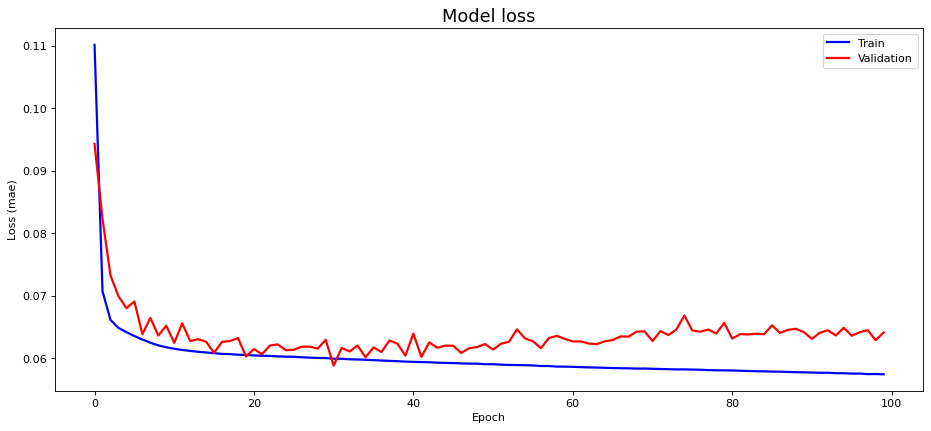

In [24]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

/home/hugo/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

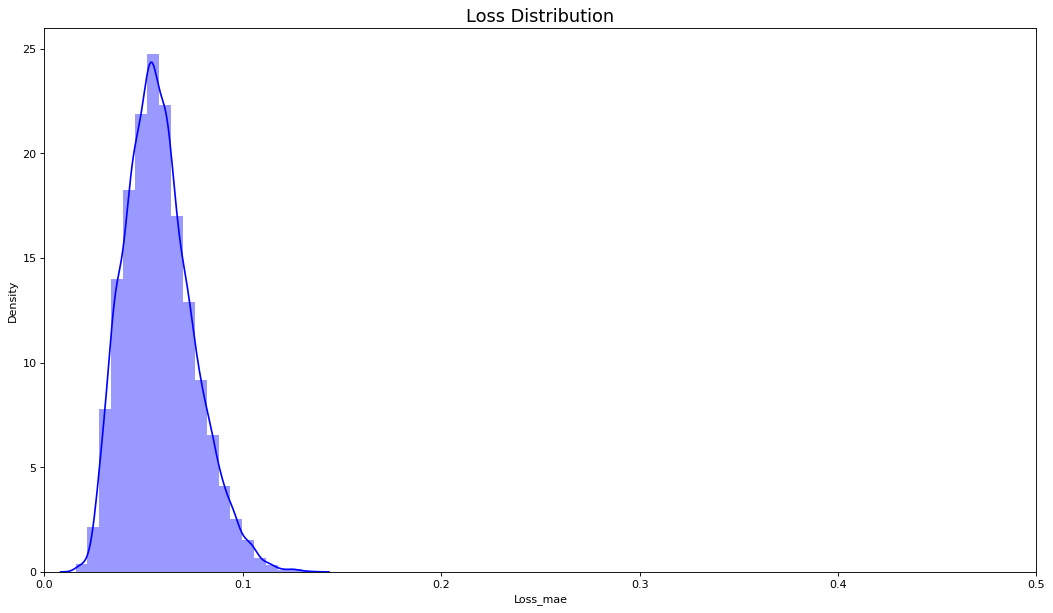

In [45]:
# plot the loss distribution of the training set
X_pred = model.predict(train_X)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = train_X.reshape(train_X.shape[0], train_X.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [53]:
# calculate the loss on the test set
X_pred = model.predict(test_X)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = test_X.reshape(test_X.shape[0], test_X.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.175
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
14801,0.063019,0.175,False
14802,0.063910,0.175,False
14803,0.065207,0.175,False
14804,0.066399,0.175,False
14805,0.062531,0.175,False


In [57]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(train_X)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.175
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

<AxesSubplot:>

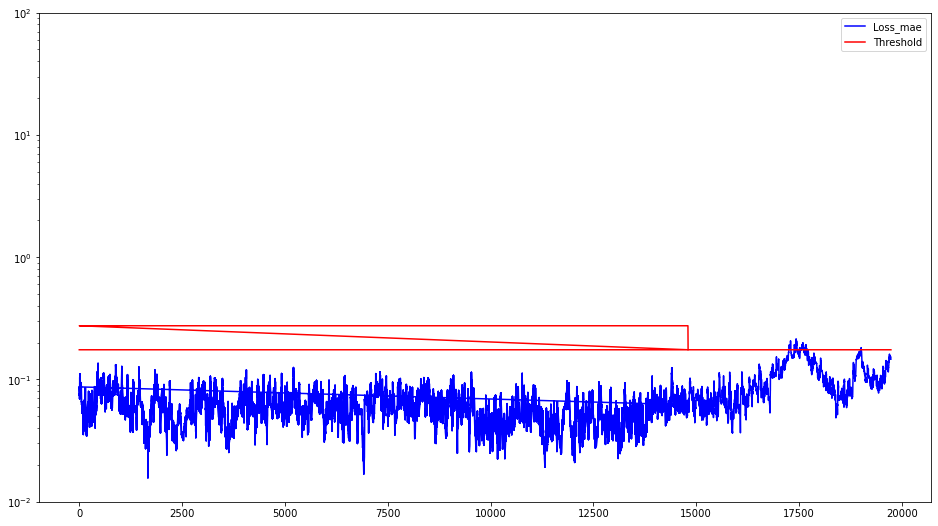

In [58]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])